# Data project

In [23]:
# Importing libaries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import pandas as pd
import pydst
dst = pydst.Dst(lang='en')

## Importing and cleaning the data

We import data from Statistics Denmark with their API package pydst, and inspect the data structure.

In [25]:
# Importing MPK13
MPK13_true = dst.get_data(table_id = 'MPK13', variables={'TYPE':['*'], 'TID': ['*']})
# Inspecting data structure
MPK13_true.head()

,TYPE,TID,INDHOLD
0,Total (OMXC end December 1995 = 100),2019M08,858
1,Energy,2019M08,3906
2,Materials,2019M08,1100
3,Industrials,2019M08,1416
4,Consumer discretions,2019M08,2100


Now that we're aware of the data structure, we create columns and name them. 

In [26]:
# Creating columns
columns_dict = {}
columns_dict['TYPE'] = 'variable'
columns_dict['TID'] = 'month'
columns_dict['INDHOLD'] = 'value'

# Creating a dictonary for the variables we want to analyze
var_dict = {} # var is for variable
var_dict['OMXC 20 Cap (28th November 2011 = 400)'] = 'OMX' #Benchmark index
var_dict['Industrials'] = 'Industrials'
var_dict['Financials'] = 'Financials'
var_dict['Information technology'] = 'IT'

In [27]:
# Naming columns
MPK13_true.rename(columns=columns_dict,inplace=True)

for key,value in var_dict.items():
   MPK13_true.variable.replace(key,value,inplace=True)

We're now cleaning the data by limiting data to the necessary variables. We ommit any variables which are not included in the variable dictionary. 

In [28]:
# Limiting the variables to necessary ones
I = False

MPK13_true['value'].replace('..','0',inplace=True)
for key,value in var_dict.items():
    I = I | (MPK13_true.variable == value)
MPK13_true = MPK13_true[I]

MPK13_true.value = MPK13_true.value.astype('float')

In [29]:
# Investigating the data structure 
MPK13_true.head()

,variable,month,value
3,Industrials,2019M08,1416.0
7,Financials,2019M08,1451.0
8,IT,2019M08,5507.0
10,OMX,2019M08,1140.0
18,Industrials,2019M03,1426.0


The data comes with a 0,..,N structure. As we have time series data, captured every month, we change the index to month. 

In [17]:
# Reindexing to the date, such that we have time series data
mpk13 = MPK13_true.set_index('month')
mpk13.head()

,variable,value
month,,
2019M08,Industrials,1416.0
2019M08,Financials,1451.0
2019M08,IT,5507.0
2019M08,OMX,1140.0
2019M03,Industrials,1426.0


The variables are still in rows, and not by a column structure, so we pivot the table, such that every variable has a column, with their values in the rows.

In [30]:
# Adding columns for variables
res = mpk13.pivot(columns='variable', values='value')
res.tail()

variable,Financials,IT,Industrials,OMX
month,,,,
2019M10,1506.0,5475.0,1479.0,1153.0
2019M11,1508.0,6199.0,1610.0,1221.0
2019M12,1639.0,6613.0,1661.0,1256.0
2020M01,1690.0,6640.0,1534.0,1285.0
2020M02,1564.0,6104.0,1356.0,1229.0


## Analysis
We calculate growth rates and average monthly growth rates. We create columns for them in the dataframe, such that we can display it all in one table. We display the table from 2013 to 2020, as OMX is the only variable with data prior to 2013. 

In [19]:
# Calculating monthly growth rates and appending to dataframe
res['OMX growth rate'] = ((res['OMX'] - res['OMX'].shift()) / res['OMX'].shift()) * 100 
res['Industrials growth rate'] = ((res['Industrials'] - res['Industrials'].shift()) / res['Industrials'].shift()) * 100
res['Financials growth rate'] = ((res['Financials'] - res['Financials'].shift()) / res['Financials'].shift()) * 100
res['IT growth rate'] = ((res['IT'] - res['IT'].shift()) / res['IT'].shift()) * 100

# Calculating the avg. monthly growth rates for each index
res['Avg. monthly growth rate OMX'] = ((res['OMX']['2020M02'] / res['OMX']['2013M01']) ** (1 / (12*7+2-1)) - 1) * 100
res['Avg. monthly growth rate Industrials'] = ((res['Industrials']['2020M02'] / res['Industrials']['2013M01']) ** (1 / (12*7+2-1)) - 1) * 100
res['Avg. monthly growth rate Financials'] = ((res['Financials']['2020M02'] / res['Financials']['2013M01']) ** (1 / (12*7+2-1)) - 1) * 100
res['Avg. monthly growth rate IT'] = ((res['IT']['2020M02'] / res['IT']['2013M01']) ** (1 / (12*7+2-1)) - 1) * 100

#Displaying the table
res.tail(12*7+2) # 7 years of 12 months plus 2 months of 2020

variable,Financials,IT,Industrials,OMX,OMX growth rate,Industrials growth rate,Financials growth rate,IT growth rate,Avg. monthly growth rate OMX,Avg. monthly growth rate Industrials,Avg. monthly growth rate Financials,Avg. monthly growth rate IT
month,,,,,,,,,,,,
2013M01,1098.0,1358.0,977.0,554.0,inf,inf,inf,inf,0.941809,0.386401,0.417051,1.783879
2013M02,1138.0,1496.0,1031.0,575.0,3.790614,5.527124,3.642987,10.162003,0.941809,0.386401,0.417051,1.783879
2013M03,1148.0,1586.0,1026.0,572.0,-0.521739,-0.484966,0.878735,6.016043,0.941809,0.386401,0.417051,1.783879
2013M04,1194.0,1667.0,949.0,566.0,-1.048951,-7.504873,4.006969,5.107188,0.941809,0.386401,0.417051,1.783879
2013M05,1237.0,1768.0,958.0,581.0,2.650177,0.948367,3.601340,6.058788,0.941809,0.386401,0.417051,1.783879
...,...,...,...,...,...,...,...,...,...,...,...,...
2019M10,1506.0,5475.0,1479.0,1153.0,0.786713,2.211472,-0.986193,1.482854,0.941809,0.386401,0.417051,1.783879
2019M11,1508.0,6199.0,1610.0,1221.0,5.897658,8.857336,0.132802,13.223744,0.941809,0.386401,0.417051,1.783879
2019M12,1639.0,6613.0,1661.0,1256.0,2.866503,3.167702,8.687003,6.678497,0.941809,0.386401,0.417051,1.783879


The data frame above shows monthly growth rate by sector from 2013Q1 to 2020Q1, this is useful for monthly inspection of sector performances. To obtain a clear picture of the perfomances of the sectors, we calculate the total growth rates by sector and compare them to the benchmark.

In [20]:
# Total growth over the period 
print("Total growth by sector:")
totalgrowthOMX = ((res['OMX']['2020M02'] / res['OMX']['2013M01']) - 1) * 100
print("Benchmark, OMXC:",round(totalgrowthOMX,2))
totalgrowthIndustrials = ((res['Industrials']['2020M02'] / res['Industrials']['2013M01']) - 1) * 100
print("Industrials:", round(totalgrowthIndustrials,2))
totalgrowthFinancials = ((res['Financials']['2020M02'] / res['Financials']['2013M01']) - 1) * 100
print("Financials:", round(totalgrowthFinancials,2))
totalgrowthIT = ((res['IT']['2020M02'] / res['IT']['2013M01']) - 1) * 100
print("IT:", round(totalgrowthIT,2))

Total growth by sector:
Benchmark, OMXC: 121.84
Industrials: 38.79
Financials: 42.44
IT: 349.48


IT is outperforming every other considered sector and the benchmark. IT is the only sector which performs better than the benchmark.

## Illustration of data

To get a clear clear picture of the monthly performance of the sectors, we display the sector index growth and growth rates. 

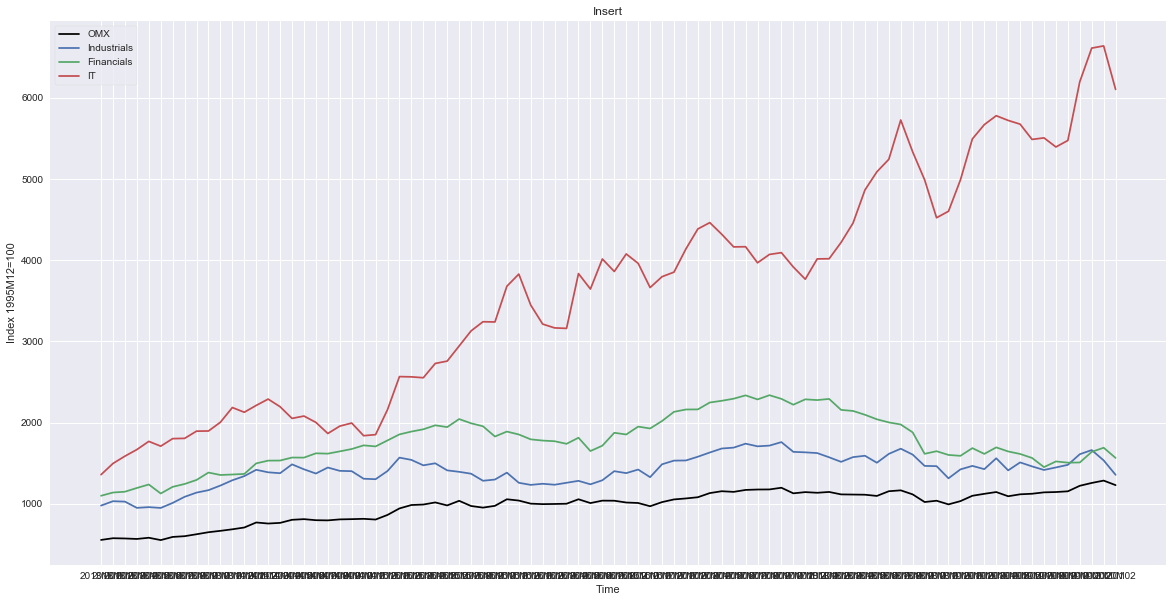

In [21]:
#Initiate figure
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(1,1,1)


ax.plot(res['OMX']['2013M01':], color = 'black', label = 'OMX')
ax.plot(res['Industrials']['2013M01':], label = 'Industrials')
ax.plot(res['Financials']['2013M01':], label = 'Financials')
ax.plot(res['IT']['2013M01':], label = 'IT')


#Trying to configure the x-axis, moving every second tick down
#labels_formatted = [res[:1] if i%2==0 else res[:1]+' '*3 for i,res[:1] in enumerate(res[:1])]
#ax.set_xticklabels(labels_formatted)

#Formatting the visual presentation
ax.set_xlabel('Time')
ax.set_ylabel('Index 1995M12=100')
ax.set_title('Insert')
ax.grid(True)
ax.legend(loc = 'upper left', frameon = True)

IT starts its significant outperformance in ... IT is not only the best performoning, but also most volatile. Which is as expected, when you have large growth, you can also expect large volatility.

Text(0.5, 1.0, 'IT')

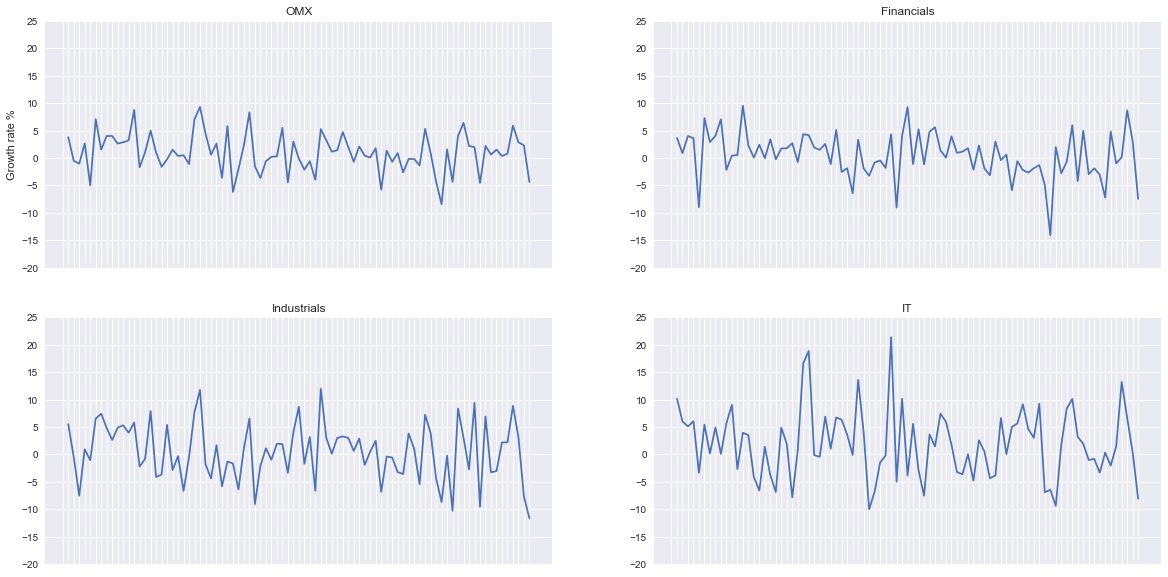

In [22]:
#Initiate figure
fig, ax = plt.subplots(2,2, figsize = (20,10))

ax[0,0].plot(res['OMX growth rate']['2013M01':])
ax[1,0].plot(res['Industrials growth rate']['2013M01':])
ax[0,1].plot(res['Financials growth rate']['2013M01':])
ax[1,1].plot(res['IT growth rate']['2013M01':])


#Formatting the visual presentation
ax[0,0].set_ylim(-20, 25)
ax[1,0].set_ylim(-20, 25)
ax[0,1].set_ylim(-20, 25)
ax[1,1].set_ylim(-20, 25)
ax[0,0].set_xticklabels([])
ax[1,0].set_xticklabels([])
ax[0,1].set_xticklabels([])
ax[1,1].set_xticklabels([])
ax[0,0].set_ylabel('Growth rate %')
ax[0,0].set_title('OMX')
ax[1,0].set_title('Industrials')
ax[0,1].set_title('Financials')
ax[1,1].set_title('IT')

## Conclusion
Information technology is the driver of the OMXC index, outperforming the other sectors significantly. The data looks as expected, as media has discussed the emerging IT industry for a while. It's interesting how much of a driver IT is for the OMXC, which becomes clear in the *Total growth by sector* section.  